In [62]:
"""
Next Steps:
Try XGBoost
Try t-SNE (https://github.com/danielfrg/tsne)
Build ensamble model
Try TPOT
http://fastml.com/revisiting-numerai/
https://medium.com/jim-fleming/notes-on-the-numerai-ml-competition-14e3d42c19f3
https://github.com/jimfleming/numerai
"""

# Imports
import os
import numpy as np
from scipy.ndimage import imread
import cv2
import sklearn.utils
import pandas as pd
import keras
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras.layers import Dense, Activation, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras import optimizers
from keras import losses
from keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
from IPython.display import clear_output
#import xgboost as xgb

In [64]:
training_df = pd.read_csv("./numerai_datasets/numerai_training_data.csv") #393613 rows (0-393612)
tournament_df = pd.read_csv("./numerai_datasets/numerai_tournament_data.csv") #243484 rows (0-243483)

In [65]:
validation_df = tournament_df.loc[tournament_df['data_type'] == "validation"] # 46362 rows (0-46361)
test_df = tournament_df.loc[tournament_df['data_type'] == "test"] #192605 rows (46362-238966)
live_df = tournament_df.loc[tournament_df['data_type'] == "live"] #4517 rows (238967-243483)
predict_df = tournament_df.loc[tournament_df['data_type'] != "validation"] # 197122 rows (46362-243483)

In [66]:
SELECT_SUBSET_PERCENT = 1.0

select_count_train = int(len(training_df)*SELECT_SUBSET_PERCENT)
select_count_valid = int(len(validation_df)*SELECT_SUBSET_PERCENT)

train_X = np.array(training_df.iloc[:select_count_train,3:-1])
train_Y = np.array(training_df.iloc[:select_count_train,-1:])

validation_X = np.array(validation_df.iloc[:select_count_valid,3:-1])
validation_Y = np.array(validation_df.iloc[:select_count_valid,-1:])

In [67]:
# Initialize simple neural network model
model = Sequential()

# Hidden layer 1: 4096 neurons, 'relu' activation
model.add(Dense(units=4096, input_dim=50))
model.add(Activation('relu'))

model.add(BatchNormalization())
model.add(Dropout(0.4))

# Hidden layer 2: 1024 neurons, 'relu' activation
model.add(Dense(units=1024))
model.add(Activation('relu'))

model.add(BatchNormalization())
model.add(Dropout(0.4))

# Hidden layer 3: 256 neurons, 'relu' activation
model.add(Dense(units=256))
model.add(Activation('relu'))

model.add(BatchNormalization())
model.add(Dropout(0.4))

# Hidden layer 4: 32 neurons, 'relu' activation
model.add(Dense(units=32))
model.add(Activation('relu'))

model.add(BatchNormalization())
model.add(Dropout(0.4))

# Output layer: 1 neurons, sigmoid
model.add(Dense(units=1))
model.add(Activation('sigmoid'))

optimizer = optimizers.RMSprop()
loss = "binary_crossentropy"
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

In [68]:
# updatable plot
# a minimal example (sort of)

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

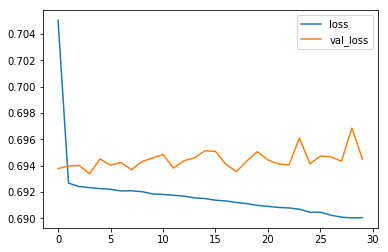

314890/314890 [==============================] - 390s 1ms/step - loss: 0.6900 - acc: 0.5318 - val_loss: 0.6945 - val_acc: 0.5044


In [70]:
BATCH_SIZE = 256 # try 32
EPOCHS = 30

#model.fit(train_X, train_Y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, verbose=1, shuffle=True)
#model.fit(train_X, train_Y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, callbacks=[early_stopping], verbose=1, shuffle=True)
model.fit(train_X, train_Y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, callbacks=[plot_losses], verbose=1, shuffle=True)

In [71]:
loss, acc = model.evaluate(validation_X, validation_Y, batch_size=BATCH_SIZE, verbose=1)

print()
print('Got %.2f%% accuracy' % (acc * 100.))
print('Loss: ', loss)

46362/46362 [==============================] - 17s 373us/step

Got 51.21% accuracy
Loss:  0.694020559986


In [72]:
predicted_df = model.predict(tournament_df.iloc[:,3:-1])
final_predictions_df = pd.DataFrame(np.concatenate((tournament_df.iloc[:,:1].values, predicted_df), axis=1))

In [73]:
final_predictions_df.to_csv('predictions_stenger3.csv', index=None)

In [74]:
print('Saved: {}'.format('predictions_stenger3.csv'))

Saved: predictions_stenger3.csv
